# Project Market Risk

Majeure : Majeure: Ingénieurie Financière

Gilles Delpy Sop Fofou 
 ||  Barthélémy Bengloan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Question A (Ex2, part of Q1 and of Q2 of TD1) 

#### A.a)

Firstly we are going to prepare the dataset on which we'll be working to answer the question

Importation of the Natixis Stock

In [12]:
data = pd.read_csv("TD1 natixis.csv", sep = ";", decimal = ",")
data

,date,price
0,02/01/2015,5.621
1,05/01/2015,5.424
2,06/01/2015,5.329
3,07/01/2015,5.224
4,08/01/2015,5.453
...,...,...
1018,21/12/2018,4.045
1019,24/12/2018,4.010
1020,27/12/2018,3.938
1021,28/12/2018,4.088


In [13]:
data.dtypes

date      object
price    float64
dtype: object

we want to manipulate date so let's convert them to DateTime.

In [14]:
data["date"] = pd.to_datetime(data["date"], format="%d/%m/%Y")
data

,date,price
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453
...,...,...
1018,2018-12-21,4.045
1019,2018-12-24,4.010
1020,2018-12-27,3.938
1021,2018-12-28,4.088


Let's compute the returns

In [15]:
data['price_return'] = data['price'].pct_change()
data

,date,price,price_return
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
...,...,...,...
1018,2018-12-21,4.045,-0.001481
1019,2018-12-24,4.010,-0.008653
1020,2018-12-27,3.938,-0.017955
1021,2018-12-28,4.088,0.038090


For the rest of the manipulations, as the first return is not defined, we will delete it and manipulate the data between the years 2015 and 2016.

In [16]:
data_15_16 = data[data["date"].dt.year < 2017].copy()
data_15_16.dropna(inplace = True)
data_15_16

,date,price,price_return
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
5,2015-01-09,5.340,-0.020723
...,...,...,...
508,2016-12-23,5.376,-0.008118
509,2016-12-27,5.380,0.000744
510,2016-12-28,5.379,-0.000186
511,2016-12-29,5.328,-0.009481


Now that our datset is ready we can answer the question !

Non-parametric VaR is defined using the non-parametric Kernel distribution :
$$
\hat{F}_n(x) := \frac{1}{n} \sum_{i = 1}^n Kappa \left(\frac{x-X_i}{h}\right)
$$
Where :
- $n$ : number of observations.
- $h$ : bandwith, smoothing parameter. 
- $Kappa$ : the logistic Kernel 


The logistic Kernel defined :
$$
Kappa(x) = \frac{1}{1 + e^{-x}}, \quad K(x) = \frac{e^{-x}}{1 - e^{-x}}.
$$

We define the Kernel function and then the estimator of $F$ :

In [17]:
K = lambda x: 1/(1 + np.exp(-x)) # Logistic distribution

def F_Kernel_Estimator(data, h, x):
    n = len(data)
    return 1/n * sum([K((x - data[i])/h) for i in range(n)])


We're also going to make a vectorised version, as we're going to take vectors into account. 

In [18]:
def F_Kernel_Estimator_Vec(data, h, X):
    n = len(data)
    return np.array([np.sum(1 / (1 + np.exp(-(x - data) / h))) / n for x in X])

### 

 Now to chose the right bandwidth, we will use a graph and test for different value of h 

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


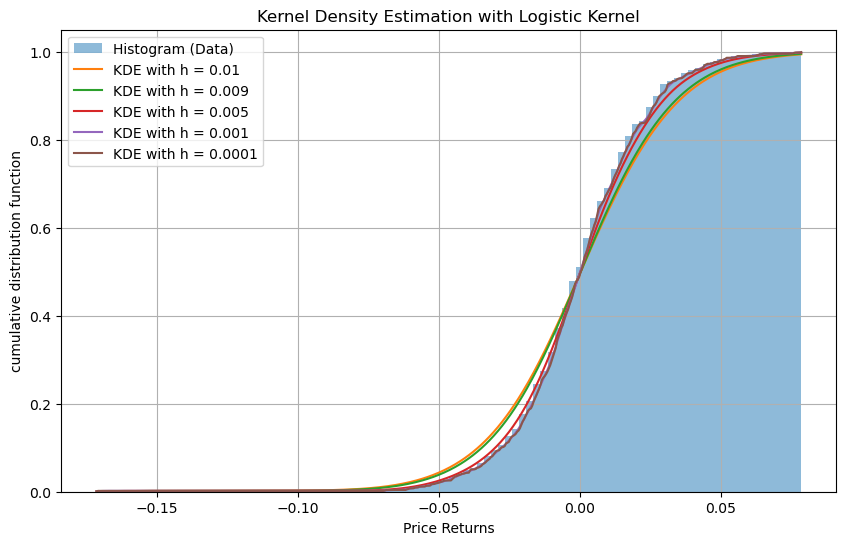

In [19]:
price_return = data_15_16['price_return']

x_values = np.linspace(price_return.min(), price_return.max(), 512) # Values for the x-axis, starting from the minimum value of the data to the maximum value.

H = [0.01, 0.009, 0.005, 0.001, 0.0001] # Bandwidths.

plt.figure(figsize = (10, 6))
plt.hist(price_return, bins = 100, density = True, alpha = 0.5, label = 'Histogram (Data)', cumulative = True) # Plotting the cdf of the data.
for h in H:
    kde = F_Kernel_Estimator_Vec(price_return, h, x_values)
    plt.plot(x_values, kde, label = f'KDE with h = {h}')
    
plt.title('Kernel Density Estimation with Logistic Kernel')
plt.xlabel('Price Returns')
plt.ylabel('cumulative distribution function')
plt.legend()
plt.grid()
plt.show()

The kernel density estimation for $h = 0.01$ or $h = 0.009$ smoothes the distribution a little too strongly unlinke the parameter $h = 0.0001$ which over-learns the distribution

So now we only have $h = 0.005$ and $h = 0.001$ , we want to focus on the lower tail of the distribution. Since these are price returns, the VaR will be on the lower end of the graph. If we zoom in on that part of the graph :

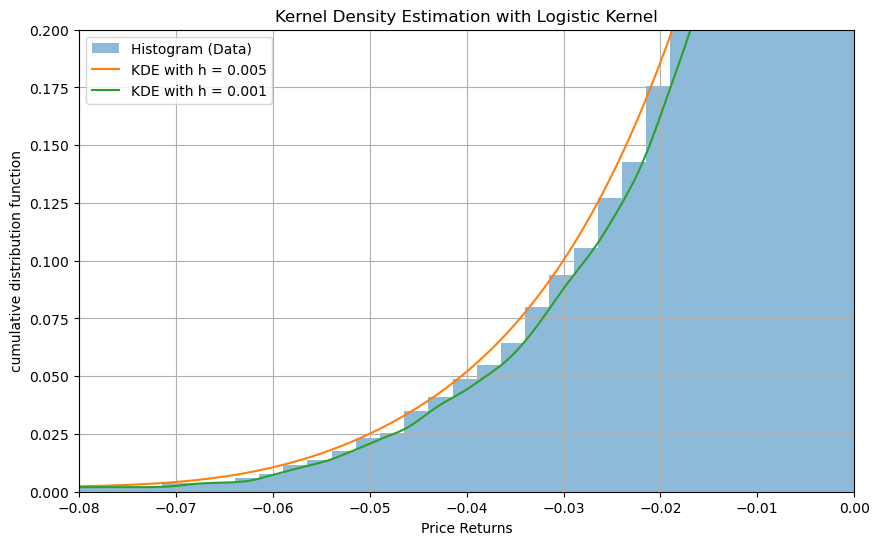

In [20]:
H = [0.005, 0.001]
plt.figure(figsize = (10, 6))
plt.hist(price_return, bins = 100, density = True, alpha = 0.5, label = 'Histogram (Data)', cumulative = True) # Plotting the cdf of the data.
for h in H:
    kde = F_Kernel_Estimator_Vec(price_return, h, x_values)
    plt.plot(x_values, kde, label = f'KDE with h = {h}')
    
plt.title('Kernel Density Estimation with Logistic Kernel')
plt.xlabel('Price Returns')
plt.ylabel('cumulative distribution function')
plt.xlim(-0.08, 0)
plt.ylim(0, 0.2)
plt.legend()
plt.grid()
plt.show()

Les deux parametres sont plutot correct, cependant en risk, il vaut mieux le surestimer. therefore we choose $$ h = 0.005 $$

Then, we proceed with the computation of the VaR based on the estimation we just did. To do so, we will simply go through the values we computed and stop whenever we hit the threshold.

In [21]:
h=0.005
def Compute_VaR(price_return, alpha, h, grid_size = 500):
    x_values = np.linspace(price_return.min(), price_return.max(), grid_size)
    for x in x_values:
        if F_Kernel_Estimator(price_return, h, x) >= 1 - alpha:
            return x
    return None  # Return None if no value is found (edge case)

Example if $\alpha$ = 95%

In [22]:
Compute_VaR(np.array(price_return), 0.95, h)

-0.040190534624647445

Conclusion the VaR at $95\%$ of the Natixis stock is a negative return of $4 \%$.

### Question A (Ex2, part of Q1 and of Q2 of TD1) 

#### A.b)

So we need to check that 95% of the returns, at least, are above $-4\%$ on a different time period.

In [23]:
data_17_18 = data[data["date"].dt.year > 2016]
data_17_18

,date,price,price_return
513,2017-01-02,5.400,0.007463
514,2017-01-03,5.620,0.040741
515,2017-01-04,5.641,0.003737
516,2017-01-05,5.595,-0.008155
517,2017-01-06,5.563,-0.005719
...,...,...,...
1018,2018-12-21,4.045,-0.001481
1019,2018-12-24,4.010,-0.008653
1020,2018-12-27,3.938,-0.017955
1021,2018-12-28,4.088,0.038090


In [24]:
def validation(price_return, alpha):
    VaR = Compute_VaR(np.array(price_return), 0.95, h)
    Count = 0
    for x in price_return:
        if x < VaR: # We trust our estimations of the distribution better in the lower tail.
            Count += 1
    return 1 - Count / len(data) # Proportion of values above the VaR.

In [25]:
validation(data_17_18["price_return"], 0.95)

0.9824046920821115

Concluion the non-parametric VaR is validated

### Question B (Ex2, Q4 of TD2)

For this question we want all of the dataset 

In [26]:
data

,date,price,price_return
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
...,...,...,...
1018,2018-12-21,4.045,-0.001481
1019,2018-12-24,4.010,-0.008653
1020,2018-12-27,3.938,-0.017955
1021,2018-12-28,4.088,0.038090


We compute the log returns :

In [27]:
data_Q2 = data.copy()
data_Q2['log_returns'] = np.log(data_Q2['price'] / data_Q2['price'].shift(1))
data_Q2

,date,price,price_return,log_returns
0,2015-01-02,5.621,NaN,NaN
1,2015-01-05,5.424,-0.035047,-0.035676
2,2015-01-06,5.329,-0.017515,-0.017670
3,2015-01-07,5.224,-0.019704,-0.019900
4,2015-01-08,5.453,0.043836,0.042903
...,...,...,...,...
1018,2018-12-21,4.045,-0.001481,-0.001482
1019,2018-12-24,4.010,-0.008653,-0.008690
1020,2018-12-27,3.938,-0.017955,-0.018118
1021,2018-12-28,4.088,0.038090,0.037383


Exponential weighting,
$$
w_t = \lambda^{T - t},
$$
with $\lambda \in (0,1)$ : exponential weighting parameter for the volatility.

Foe example, we chose :

In [28]:
lambda_ = 0.92

We apply the weights :

In [32]:
weights = np.array([lambda_**i for i in range(len(data_Q2))][::-1]) # Weights for the exponentially weighted moving average, in reverse order

data_Q2["Weighted_log_returns"] = data_Q2["log_returns"] * weights / sum(weights)

data_Q2

,date,price,price_return,log_returns,Weighted_log_returns
0,2015-01-02,5.621,NaN,NaN,NaN
1,2015-01-05,5.424,-0.035047,-0.035676,-3.039753e-40
2,2015-01-06,5.329,-0.017515,-0.017670,-1.636474e-40
3,2015-01-07,5.224,-0.019704,-0.019900,-2.003290e-40
4,2015-01-08,5.453,0.043836,0.042903,4.694411e-40
...,...,...,...,...,...
1018,2018-12-21,4.045,-0.001481,-0.001482,-8.494780e-05
1019,2018-12-24,4.010,-0.008653,-0.008690,-5.413632e-04
1020,2018-12-27,3.938,-0.017955,-0.018118,-1.226824e-03
1021,2018-12-28,4.088,0.038090,0.037383,2.751379e-03


Then, the weighted parameters are given by :
$$
\hat{\mu}_w = \frac{\sum_{t} w_t \ln(R_t)}{\sum_{t} w_t}, \quad \hat{\sigma}_w = \frac{\sum_{t} w_t \left(\ln(R_t) - \hat{\mu}_w \right)^2}{\sum_{t} w_t}
$$

In [33]:
mu_w = np.sum(weights * data_Q2['log_returns']) / np.sum(weights)
sigma_w = np.sqrt(np.sum(weights * (data_Q2['log_returns'] - mu_w)**2) / np.sum(weights))
print(f"mu_w = {mu_w}, sigma_w = {sigma_w}")

mu_w = -0.006236493446561692, sigma_w = 0.0245635361811459


Let $S_0$ be the price at the last date of 2018, the price at the next time is $S_1$ and is given by :
$$
S_1 = S_0 \exp\left(\hat{\sigma}_w B_1 + \hat{\mu}_w - \frac12 \hat{\sigma}_w\right), \quad B_1 \sim \mathcal{N}(0, 1).
$$


We proceed with the simulation :
We take the number of the simulation N 
with $S_0$ the price at the last date of 2018

In [34]:
N = 1000 
S_0 = data_Q2['price'].iloc[-1] 
B_1 = np.random.normal(0, 1, N)  # N standard normal samples

# prices simulation
simulated_prices = S_0 * np.exp(sigma_w * B_1 + mu_w - 0.5 * sigma_w**2)

The price of a European Call Option is given, according to the Black-Scholes- Merton formula, by :
$$
C = S_t \times \Phi(d_1) - K e^{-r T} \times \Phi(d_2),
$$
where:
- $K$ : Strike price.
- $r = 0$ : Risk-free rate.
- $T = 1/252$ : Time to maturity (1 day).
- $\Phi(d)$ : Cumulative normal distribution function.
- $d_1 = \frac{\ln(S_t / K) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}$, $d_2 = d_1 - \sigma \sqrt{T}$.


In [35]:
from scipy.stats import norm

T = 1/252
r = 0
K = S_0
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [36]:
simulated_call_prices = black_scholes_call(simulated_prices, K, T, r, sigma_w)
simulated_call_prices

array([2.64105056e-039, 2.77668137e-010, 1.18120074e-001, 5.70100146e-002,
       1.28765940e-002, 1.55390519e-005, 2.72212018e-001, 0.00000000e+000,
       2.11489898e-016, 1.39590685e-173, 1.21537477e-062, 2.85818695e-011,
       1.72645843e-006, 5.92672390e-064, 1.43133453e-001, 2.76981969e-239,
       1.16318411e-002, 0.00000000e+000, 1.97411273e-010, 6.99083744e-002,
       6.75185871e-244, 8.05674040e-002, 2.79628479e-002, 2.04409728e-007,
       4.78619760e-044, 2.38913078e-002, 1.71553834e-029, 9.64477260e-181,
       1.96065954e-001, 3.12360312e-002, 3.22508695e-009, 1.34568352e-160,
       3.04353286e-001, 1.19782522e-154, 1.69085344e-001, 1.42691316e-002,
       0.00000000e+000, 1.41988363e-003, 4.87330206e-002, 6.09771317e-002,
       5.02356682e-002, 3.38012245e-070, 6.10103742e-002, 1.48906282e-030,
       2.99624442e-019, 3.40006645e-002, 3.59956440e-141, 3.11127330e-046,
       8.23001957e-006, 8.56697068e-235, 8.84007518e-002, 1.26195410e-001,
       4.67344061e-002, 2

Now we calculate the 95% quantile of the distribution of simulated call option prices to account for 95% of the risk

In [37]:
VaR_Call = np.quantile(simulated_call_prices, 0.95)
VaR_Call

0.14057809326000206

 Conclusion, the price of the call should be less or equal to the result above (according our simulation)

### Question C (Ex2, Q1 and Q3 of TD3) 

#### C.a)

We use the same dataset 

In [38]:
data

,date,price,price_return
0,2015-01-02,5.621,NaN
1,2015-01-05,5.424,-0.035047
2,2015-01-06,5.329,-0.017515
3,2015-01-07,5.224,-0.019704
4,2015-01-08,5.453,0.043836
...,...,...,...
1018,2018-12-21,4.045,-0.001481
1019,2018-12-24,4.010,-0.008653
1020,2018-12-27,3.938,-0.017955
1021,2018-12-28,4.088,0.038090


We separate the positive and negative returns. We also make them positive.

In [39]:
data_Q3 = data["price_return"].copy()
data_Q3.dropna(inplace = True)
data_Q3_negative = abs(data_Q3[data_Q3 < 0])
data_Q3_positive = data_Q3[data_Q3 >= 0]

In [40]:
data_Q3_positive

4       0.043836
7       0.025836
9       0.020523
10      0.013284
11      0.026038
          ...   
1010    0.019595
1011    0.026287
1015    0.004512
1021    0.038090
1022    0.007583
Name: price_return, Length: 503, dtype: float64

In [41]:
data_Q3_negative

1       0.035047
2       0.017515
3       0.019704
5       0.020723
6       0.014232
          ...   
1016    0.063328
1017    0.028770
1018    0.001481
1019    0.008653
1020    0.017955
Name: price_return, Length: 519, dtype: float64

#### Recall Pickands estimator

Let $(X_n)$ be a sequence of i.i.d. random variables, whose cdf $F$ belongs to the max-domain of attraction of a GEV distribution of parameter $\xi \in \mathbb{R}$.<br> $X_{i : n}$ represent the order statistics of the sample $(X_1, X_2, \dots, X_n)$, such that:
$$
X_{1:n} \leq X_{2:n} \leq \dots \leq X_{n:n}$$
Let $k$ be a function $\mathbb{N} \to \mathbb{N}$. If
$$
\lim_{n \to \infty} k(n) = \infty
$$
and
$$
\lim_{n \to \infty} \frac{k(n)}{n} = 0,
$$
then, the pickhands estimator of the GEV parameter $\xi$ is given by :
$$
\xi_{k(n), n}^{P} = \frac{1}{\log(2)} \log\left(\frac{X_{n - k(n) + 1 : n} - X_{n - 2k(n) + 1 : n}}{X_{n - 2k(n) + 1 : n} - X_{n - 4k(n) + 1 : n}}\right),
$$


We define the following functions :

In [42]:
k = lambda n : n**(1/5)

It satifies the condition for the convergence of the estimator. We compute the estimator :

In [43]:
def Pickands_estimator(price_return, k):
    n = len(price_return)
    price_reutrn_sorted = np.sort(price_return)
    
    x_nk = price_reutrn_sorted[int(np.floor(-k(n) + 1))] 
    x_n2k = price_reutrn_sorted[int(np.floor(-2*k(n) + 1))]  
    x_n4k = price_reutrn_sorted[int(np.floor(-4*k(n) + 1))] 
    
    delta_num = x_nk - x_n2k
    delta_den = x_n2k - x_n4k
    delta = delta_num / delta_den
    
    return np.log(delta) / np.log(2)

Let's test

In [44]:
Pickands_estimator(data_Q3_negative, k)

-0.30172719722799335

So $\xi < 0$, the nature of the negative returns are of the Weibull kind

In [45]:
Pickands_estimator(data_Q3_positive, k)

0.06277031346758448

So $\xi > 0$, the nature of the positive returns are of the Fréchet kind

#### C.b)

We want to compute this quatity:
$$
\hat{\theta}_n^B(u; b) = \frac{\sum_{i=1}^k \mathbb{1}(M_{(i-1)b, ib} > u)}{\sum_{i=1}^{kb} \mathbb{1}(X_i > u)} 
$$

Where $b$ is the size of the blocks, $u$ a threshold

In [46]:
def extremal_index_blocks(price_return, u, b):
    n_blocks = len(price_return) // b
    blocks = [price_return[i * b: (i + 1) * b] for i in range(n_blocks)]
    cluster_count = sum(1 for block in blocks if np.max(block) > u)
    over_thresh = np.sum(price_return > u)
    theta = cluster_count / over_thresh if over_thresh > 0 else 0 #extremal index
    return theta

So we compute and we get :

In [47]:
extremal_index_blocks(data_Q3, 0.04, 10)

0.7931034482758621

### Question D (Ex2, Q3 and Q4 of TD4) 

#### D.a) 

For this question we use the dataset of the td4 

In [53]:
data_TD4=pd.read_csv("DatasetTD4.csv",sep=";")
data_TD4.head()

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction)
0,"0,000202","0,11",8.0,-1,100
1,"0,00107","0,103",NaN,1,"99,984"
2,"0,001496","0,1015",NaN,-1,"100,029"
3,"0,003336","0,092",NaN,1,"99,979"
4,"0,003952","0,1106",NaN,1,"100,06"


In [54]:
data_TD4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   transaction date (1=1day=24 hours)    1001 non-null   object 
 1   bid-ask spread                        1001 non-null   object 
 2   volume of the transaction (if known)  137 non-null    float64
 3   Sign of the transaction               1001 non-null   int64  
 4   Price (before transaction)            1001 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 39.2+ KB


we need to convert in float

In [55]:
columns = ['transaction date (1=1day=24 hours)', 'bid-ask spread', 'Price (before transaction)']

# Loop through the columns and replace commas and convert to float
for i in columns:
    data_TD4[i] = data_TD4[i].str.replace(',', '.').astype(float)

In [56]:
data_TD4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   transaction date (1=1day=24 hours)    1001 non-null   float64
 1   bid-ask spread                        1001 non-null   float64
 2   volume of the transaction (if known)  137 non-null    float64
 3   Sign of the transaction               1001 non-null   int64  
 4   Price (before transaction)            1001 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 39.2 KB


We are going to use 2 methods:<br>
1) The linear regression method that we used in class. However, we noticed that this method was not very well adapted to our needs
2) Theoretical method that we're going to explain in detail

In [ ]:
data_Q4["price_variation"]=data_Q4["Price (before transaction)"].diff()
data_Q4['volume_sign'] = (data_Q4['volume of the transaction (if known)'] * data_Q4['Sign of the transaction'])
data_Q4

The linear regression method that we used in class. However, we noticed that this method was not very well adapted to our needs


In [57]:
data_TD4["sign x vol_transaction"]=data_TD4["volume of the transaction (if known)"] * data_TD4["Sign of the transaction"]
data_TD4["price variation"]=data_TD4['Price (before transaction)'].diff().shift(-1)
data_TD4.head()

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction),sign x vol_transaction,price variation
0,0.000202,0.1100,8.0,-1,100.000,-8.0,-0.016
1,0.001070,0.1030,NaN,1,99.984,NaN,0.045
2,0.001496,0.1015,NaN,-1,100.029,NaN,-0.050
3,0.003336,0.0920,NaN,1,99.979,NaN,0.081
4,0.003952,0.1106,NaN,1,100.060,NaN,0.100


In [59]:
df_filtred = data_TD4.dropna(subset=["sign x vol_transaction"])[["price variation", "sign x vol_transaction","volume of the transaction (if known)",'Sign of the transaction',"Price (before transaction)"]]

In [60]:
from sklearn.linear_model import LinearRegression
X = df_filtred[['price variation']]  
y = df_filtred['sign x vol_transaction']
model = LinearRegression()
model.fit(X, y)

const = model.intercept_
gamma = model.coef_[0]

print("gamma =", gamma)
print("const =", const)


gamma = 1829.9192061070537
const = 2.06583877505829


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


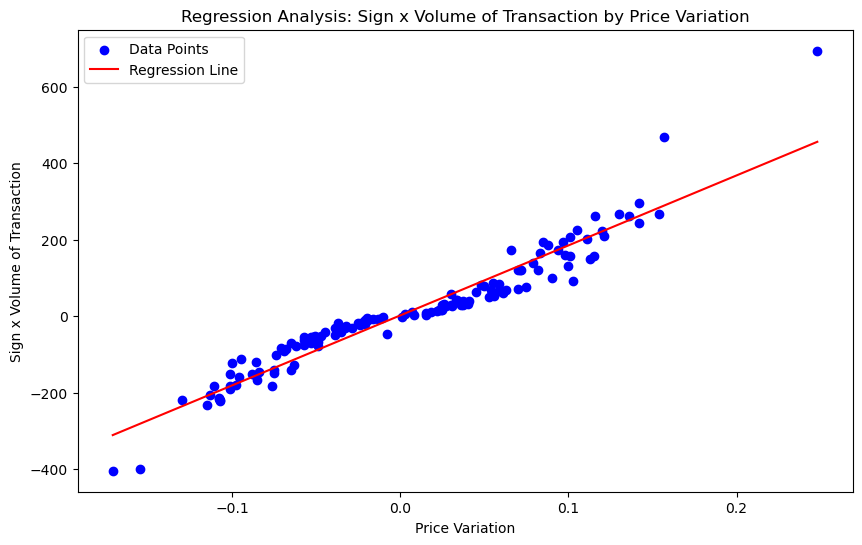

In [61]:
# Préparation des données pour le tracé de la ligne de régression
x_min_max = np.array([[X['price variation'].min()], [X['price variation'].max()]])
y_pred = model.predict(x_min_max)

# Tracé des données et de la ligne de régression
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points')  # Points de données
plt.plot(x_min_max, y_pred, color='red', label='Regression Line')  # Ligne de régression
plt.title('Regression Analysis: Sign x Volume of Transaction by Price Variation')
plt.xlabel('Price Variation')
plt.ylabel('Sign x Volume of Transaction')
plt.legend()
plt.show()

Computation of $\tau$. We are going to average the times in between executions :

In [62]:
tau = 1 / 24.0
tau

0.041666666666666664

Since $t_k = 1 \Leftrightarrow t_k = 24 \text{ hrs}$, $\tau = 24 \times t$ 

In [63]:
X=df_filtred[['price variation']] 

In [64]:
y_pred=model.predict(X)

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

volume_signed = df_filtred["sign x vol_transaction"]
volume_signed_squared = (df_filtred["volume of the transaction (if known)"].values.astype(int))*(df_filtred["volume of the transaction (if known)"].values.astype(int)) *(df_filtred['Sign of the transaction'].values.astype(int))

data_delta_price_eta =   (df_filtred['Price (before transaction)'] - df_filtred['Price (before transaction)'].shift(-1) ).values.astype(float)
data_delta_price_eta=data_delta_price_eta[:-1]
X_eta = np.column_stack((volume_signed, volume_signed_squared)) # we want to look at impact of order two
y_eta = data_delta_price_eta
X_eta=X_eta[:-1]


average_spread = np.mean(data_TD4['bid-ask spread'].values.astype(float))
epsilon = average_spread / 2

model.fit(X_eta,y_eta)

LinearRegression()

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [66]:
mse_gamma = mean_squared_error(y, y_pred)
r2_gamma = r2_score(y, y_pred)

data_TD4['Returns'] = (data_TD4['Price (before transaction)'].shift(1) - data_TD4['Price (before transaction)']) / data_TD4['Price (before transaction)']
sigma = np.std(data_TD4['Returns'])

In [67]:
#Extraction of coefficient directeur but here at order of 2
eta = model.coef_[1] * tau # 1 for the second with respect to volume_signed_squared and due to quadratic approximation we have to divide by tau
#Let's compute predicted value 
y_pred = model.predict(X_eta)
# Let's compute R2 and Mean Squared Error
mse_eta = mean_squared_error(y_eta, y_pred)
r2_eta = r2_score(y_eta, y_pred)
lam = 2E-6 
# Printing all our computed & defined parameters
print(f"Estimated Gamma: {gamma}")
print(f"Estimated Eta: {eta}")
print("Sigma:", sigma)
print("Epsilon:", epsilon)
print("Tau:", tau)
print("Lambda", lam)
#Printing our computed measure to analyze our model
print(f'MSE_gamma : {mse_gamma}')
print(f'r2_gamma : {r2_gamma}')
print(f'MSE_eta : {mse_eta}')
print(f'r2_eta: {r2_eta}')

Estimated Gamma: 1829.9192061070537
Estimated Eta: 2.624116610713045e-08
Sigma: 0.0007380476897886703
Epsilon: 0.05026138861138861
Tau: 0.041666666666666664
Lambda 2e-06
MSE_gamma : 1787.5657382836832
r2_gamma : 0.9193112589657633
MSE_eta : 0.03158091353672661
r2_eta: 0.20627651650960488


## b) Liquidation strategy :

Each tranche is computed such that :
$$
x_k = \frac{\sinh(K(T - (k - \tau / 2)))}{\sinh(KT)}X.
$$
Where :
- $X$ : Total quantity to liquidate.
- $T = 1 \text{ day}$ : Time to do so.
- $k$ : Trading period, one tick.
- $K \approx \sqrt{\frac{\lambda \sigma^2}{\eta}}$ with $\lambda$ the risk aversion. 

The data has one trading day of transactions so 24 hrs. We can only do one trade per hour.

In [82]:
X = 1000
T = 1
N = 24 # Trading periods.
tau_liq = T / N
lambda__ = 1
K = np.sqrt(sigma**2 * lambda__/ eta_hat)


x_N = np.sinh(K * (T - (np.arange(1, N + 1) - 0.5) * tau_liq)) / np.sinh(K * T) * X
x_N = x_N / np.sum(x_N) * X  # Normalize to sum up to X, without this step, we don't liquidate all the shares.

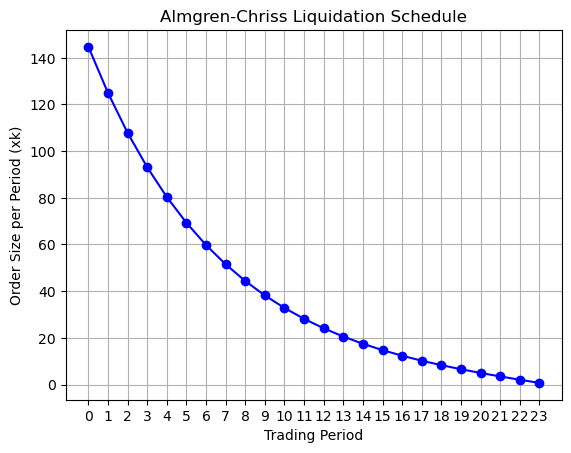

In [83]:
plt.figure()
plt.plot(range(0, N), x_N, marker = 'o', linestyle = '-', color = 'blue')
plt.xlabel('Trading Period')
plt.ylabel('Order Size per Period (xk)')
plt.title('Almgren-Chriss Liquidation Schedule')
plt.grid(True)
plt.xticks(range(0, N))
plt.show()

In [84]:
print("Liquidation Schedule:")
for i in range(len(x_N)):
    print(f"Period {i}: {x_N[i]} shares")

Liquidation Schedule:
Period 0: 144.66320648565656 shares
Period 1: 124.89515172301584 shares
Period 2: 107.81559896817747 shares
Period 3: 93.05689254163532 shares
Period 4: 80.30133546866357 shares
Period 5: 69.2743507114171 shares
Period 6: 59.738570603890714 shares
Period 7: 51.488727258489284 shares
Period 8: 44.34723395473426 shares
Period 9: 38.16036239476159 shares
Period 10: 32.794933536938856 shares
Period 11: 28.135450774248326 shares
Period 12: 24.081613746027514 shares
Period 13: 20.54615926520053 shares
Period 14: 17.452982884644594 shares
Period 15: 14.735500667394286 shares
Period 16: 12.335215896031395 shares
Period 17: 10.200459868143707 shares
Period 18: 8.285279672125222 shares
Period 19: 6.548449001499943 shares
Period 20: 4.952580714487193 shares
Period 21: 3.463322035701924 shares
Period 22: 2.048615075844063 shares
Period 23: 0.6780067512705886 shares


In [85]:
x_N.sum()

999.9999999999999

We've successfully computed the optimal liquidation strategy according to Almgren and Chriss. Having access to a dark pool would be better though.

### Question E (Q2 and Q3 of TD5) 

First we have separate each exchange rate

For CADEUR

In [98]:
data_C = pd.read_csv('TD5_CADEUR.csv', sep=	';', decimal=',', header = 1) 
data_C["average"] = 0.5 * (data_C["HIGH"] + data_C["LOW"])
data_C

,Date,HIGH,LOW,average
0,07/03/2016 09:00,0.6842,0.6829,0.68355
1,07/03/2016 09:15,0.6849,0.6841,0.68450
2,07/03/2016 09:30,0.6844,0.6837,0.68405
3,07/03/2016 09:45,0.6844,0.6839,0.68415
4,07/03/2016 10:00,0.6840,0.6835,0.68375
...,...,...,...,...
12924,07/09/2016 17:00,0.6897,0.6893,0.68950
12925,07/09/2016 17:15,0.6902,0.6895,0.68985
12926,07/09/2016 17:30,0.6902,0.6898,0.69000
12927,07/09/2016 17:45,0.6902,0.6901,0.69015


For GPEUR

In [99]:
data_G = pd.read_csv('TD5_GBPEUR.csv', sep=	';', decimal=',', header = 1) 
data_G["average"] = 0.5 * (data_G["HIGH"] + data_G["LOW"])
data_G

,Date,HIGH,LOW,average
0,07/03/2016 09:00,1.2932,1.2917,1.29245
1,07/03/2016 09:15,1.2940,1.2930,1.29350
2,07/03/2016 09:30,1.2943,1.2922,1.29325
3,07/03/2016 09:45,1.2930,1.2913,1.29215
4,07/03/2016 10:00,1.2931,1.2921,1.29260
...,...,...,...,...
12924,07/09/2016 17:00,1.1879,1.1867,1.18730
12925,07/09/2016 17:15,1.1883,1.1874,1.18785
12926,07/09/2016 17:30,1.1880,1.1874,1.18770
12927,07/09/2016 17:45,1.1874,1.1866,1.18700


For SEKEUR

In [100]:
data_S = pd.read_csv('TD5_SEKEUR.csv', sep=	';', decimal=',', header = 1) 
data_S["average"] = 0.5 * (data_S["HIGH"] + data_S["LOW"])
data_S

,Date,HIGH,LOW,average
0,07/03/2016 09:00,0.10725,0.10720,0.107225
1,07/03/2016 09:15,0.10728,0.10717,0.107225
2,07/03/2016 09:30,0.10726,0.10719,0.107225
3,07/03/2016 09:45,0.10728,0.10721,0.107245
4,07/03/2016 10:00,0.10725,0.10719,0.107220
...,...,...,...,...
12924,07/09/2016 17:00,0.10536,0.10531,0.105335
12925,07/09/2016 17:15,0.10537,0.10534,0.105355
12926,07/09/2016 17:30,0.10538,0.10536,0.105370
12927,07/09/2016 17:45,0.10537,0.10536,0.105365


#### E.a)

To answer question 2, we will also provide question 1 from the td, which we will use in questions 2/3

Recall the theory: <br> $$
\Psi^{Haar} : t \in \mathbb{R} \mapsto \mathbf{1}_{[0, 1/2)}(t) - \mathbf{1}_{[1/2, 2)}(t).
$$


Scaling Function $\phi(x)$:
For Daubechies wavelets (of which Haar is a special case), the scaling function is constructed recursively:
$$
\phi(x) = \sum_{k = 0}^{2N - 1} a_k \phi(2x - k)
$$

In our case, there is zero vanishing moments so $N = 1$, giving :
$$
\phi(x) = a_0 \phi(2x) + a_1 \phi(2x + 1)
$$

The normalization condition gives,
$$
\int_{\mathbb{R}} |\phi(x)|^2 dx = 1 \Leftrightarrow a_0^2 \int_{\mathbb{R}} |\phi(2x)|^2 dx + a_1^2 \int_{\mathbb{R}} |\phi(2x + 1)|^2 dx = a_0^2 + a_1^2 = 1 \Leftrightarrow a_0 = a_1 = \frac{1}{\sqrt{2}}
$$
Because of the orthogonality of the decomposition, $\|\phi(x)\|^2_{L^2} = \|a_1\phi(2x)\|^2_{L^2} + \|a_2\phi(2x + 1)\|^2_{L^2}$.

For the one level Haar transform :

Consider an observation $X = (x_1, \dots, x_n)$ where $n$ is even. The approximation coeficient are give by :
$$
a_{k - 1} = \frac{x_{2k} + x_{2k + 1}}{\sqrt{2}}
$$
The detail coefficient are :
$$
d_k = \frac{x_{2k} - x_{2k + 1}}{\sqrt{2}}.
$$

# 

We use the Haar transformation algorithm. We start with the one-level transformation :

In [101]:
def haar_transform_single(signal):
    n = len(signal)
    if n % 2 != 0:
        raise ValueError("Erreur") 
    approximation = []
    detail = []
    for i in range(0, n, 2):
        a = (signal[i] + signal[i + 1]) / np.sqrt(2)
        d = (signal[i] - signal[i + 1]) / np.sqrt(2)
        approximation.append(a)
        detail.append(d)
    
    return np.array(approximation), np.array(detail) # Return the coefficients as numpy arrays

Then, the recursive version :

We first calculate the transformation at the first level, then generate an approximation. This approximation is then used as the starting point for a new application of the algorithm, which is used to obtain the next level, and so on.

In [102]:
def haar_transform_recursive(signal, max_levels = None):
    coefficients = []
    current_signal = signal
    level = 0
    
    while len(current_signal) >= 2:
        if max_levels is not None and level >= max_levels:
            break  #if the desired number of levels is reached
        
        #check if the signal length is even by truncating if necessary
        if len(current_signal) % 2 != 0:
            current_signal = current_signal[:-1]  
            
        approximation, detail = haar_transform_single(current_signal)
        coefficients.append((approximation, detail))
        current_signal = approximation
        level += 1 
    
    return coefficients # tupple (approximation/detail coeff)

We can use the coefficient of our fx rate datasets to visualise the approximations and details of the coefficients

Now let's go on to the correlation analysis

We compute the coefficients of every dataset

In [103]:
coefs_cadeur = haar_transform_recursive(data_C["average"].iloc[1:].values)
coefs_gbpeur = haar_transform_recursive(data_G["average"].iloc[1:].values)
coefs_sekeur = haar_transform_recursive(data_S["average"].iloc[1:].values)

In [104]:
correlations = []
for level, (coef_cadeur, coef_gbpeur, coef_sekeur) in enumerate(zip(coefs_cadeur, coefs_gbpeur, coefs_sekeur)):
    #we only extract approximation
    approx_cadeur, _ = coef_cadeur
    approx_gbpeur, _ = coef_gbpeur
    approx_sekeur, _ = coef_sekeur
    corr_cadeur_gbpeur = np.corrcoef(approx_cadeur, approx_gbpeur)[0, 1]
    corr_cadeur_sekeur = np.corrcoef(approx_cadeur, approx_sekeur)[0, 1]
    corr_gbpeur_sekeur = np.corrcoef(approx_gbpeur, approx_sekeur)[0, 1]
    correlations.append({"Level": level + 1, "CADEUR-GBPEUR": corr_cadeur_gbpeur, "CADEUR-SEKEUR": corr_cadeur_sekeur, "GBPEUR-SEKEUR": corr_gbpeur_sekeur})

correlation_df = pd.DataFrame(correlations)
correlation_df

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Level,CADEUR-GBPEUR,CADEUR-SEKEUR,GBPEUR-SEKEUR
0,1,-0.226949,-0.135290,0.814780
1,2,-0.227190,-0.135506,0.814931
2,3,-0.227569,-0.135822,0.815184
3,4,-0.228495,-0.136924,0.815621
4,5,-0.229264,-0.137762,0.816206
5,6,-0.232206,-0.139938,0.817475
6,7,-0.241440,-0.151158,0.820864
7,8,-0.246501,-0.153196,0.825356
8,9,-0.274767,-0.183006,0.833338
9,10,-0.316037,-0.270196,0.854566


Higher level $\Leftrightarrow$ Larger time intervals. We see a clear decrease in the correlations factors so we do in fact observe the Epps effect.

#### E.b)

Recall the theory 

We define empirical absolute moments on our sample \([0, T]\) with \(1/N\) spacings:

$$
M_k = \frac{1}{NT} \sum_{i=1}^{NT} \left| X\left(\frac{i}{N}\right) - X\left(\frac{i-1}{N}\right) \right|^k
$$

Therefore we defined,
$$
M_2 = \frac{1}{NT} \sum_{i=1}^{NT} \left| X\left(\frac{i}{N}\right) - X\left(\frac{i-1}{N}\right) \right|^2
$$
and,
$$
M_2' = \frac{2}{NT} \sum_{i=1}^{NT/2} \left| X\left(\frac{2i}{N}\right) - X\left(\frac{2(i-1)}{N}\right) \right|^2
$$

The estimator of \(H\) is defined as:

$$
\hat{H} = \frac{1}{2} \log_2 \left(\frac{M_2'}{M_2}\right).
$$

Thus:

$$
\hat{H} \xrightarrow{\text{P}} H \quad \text{as } N \to \infty.
$$


Let's implement this

In [105]:
def hurst_exponent_estimator(data, N = None):   
    if N is None:
        N = len(data) - 1  # Default to all available increments
    
    M2_sum = 0
    for i in range(1, len(data)):
        increment = data[i] - data[i - 1]
        M2_sum += abs(increment)**2
    M2 = M2_sum / N  
    
    M2_prime_sum = 0
    for i in range(2, len(data), 2):
        increment2 = data[i] - data[i - 2]
        M2_prime_sum += abs(increment2)**2
    M2_prime = M2_prime_sum / (N // 2) 
    
    if M2 <= 0 or M2_prime <= 0:
        raise ValueError(f"Invalid values for M2: {M2}, M2_prime: {M2_prime}")
    

    H = 0.5 * np.log2(M2_prime / M2)
    return H

Therefore we can compute the hurst exponent estimator for our 3 dataset

In [106]:
hurst_exponent_estimator(data_C["average"])

0.6552439913406071

In [107]:
hurst_exponent_estimator(data_G["average"])

0.6714143303551333

In [108]:
hurst_exponent_estimator(data_S["average"])

0.6545913434209861

For volatility, we start by calculating the price returns for the 3 datasets

In [109]:
data_C["price_return"] = data_C["average"].pct_change()
data_C

,Date,HIGH,LOW,average,price_return
0,07/03/2016 09:00,0.6842,0.6829,0.68355,NaN
1,07/03/2016 09:15,0.6849,0.6841,0.68450,0.001390
2,07/03/2016 09:30,0.6844,0.6837,0.68405,-0.000657
3,07/03/2016 09:45,0.6844,0.6839,0.68415,0.000146
4,07/03/2016 10:00,0.6840,0.6835,0.68375,-0.000585
...,...,...,...,...,...
12924,07/09/2016 17:00,0.6897,0.6893,0.68950,0.000363
12925,07/09/2016 17:15,0.6902,0.6895,0.68985,0.000508
12926,07/09/2016 17:30,0.6902,0.6898,0.69000,0.000217
12927,07/09/2016 17:45,0.6902,0.6901,0.69015,0.000217


In [110]:
data_G["price_return"] = data_G["average"].pct_change()
data_G

,Date,HIGH,LOW,average,price_return
0,07/03/2016 09:00,1.2932,1.2917,1.29245,NaN
1,07/03/2016 09:15,1.2940,1.2930,1.29350,0.000812
2,07/03/2016 09:30,1.2943,1.2922,1.29325,-0.000193
3,07/03/2016 09:45,1.2930,1.2913,1.29215,-0.000851
4,07/03/2016 10:00,1.2931,1.2921,1.29260,0.000348
...,...,...,...,...,...
12924,07/09/2016 17:00,1.1879,1.1867,1.18730,-0.000589
12925,07/09/2016 17:15,1.1883,1.1874,1.18785,0.000463
12926,07/09/2016 17:30,1.1880,1.1874,1.18770,-0.000126
12927,07/09/2016 17:45,1.1874,1.1866,1.18700,-0.000589


In [111]:
data_S["price_return"] = data_S["average"].pct_change()
data_S

,Date,HIGH,LOW,average,price_return
0,07/03/2016 09:00,0.10725,0.10720,0.107225,NaN
1,07/03/2016 09:15,0.10728,0.10717,0.107225,0.000000e+00
2,07/03/2016 09:30,0.10726,0.10719,0.107225,-1.110223e-16
3,07/03/2016 09:45,0.10728,0.10721,0.107245,1.865237e-04
4,07/03/2016 10:00,0.10725,0.10719,0.107220,-2.331111e-04
...,...,...,...,...,...
12924,07/09/2016 17:00,0.10536,0.10531,0.105335,1.424231e-04
12925,07/09/2016 17:15,0.10537,0.10534,0.105355,1.898704e-04
12926,07/09/2016 17:30,0.10538,0.10536,0.105370,1.423758e-04
12927,07/09/2016 17:45,0.10537,0.10536,0.105365,-4.745184e-05


The annualized volatility scales as:

$$
\delta^H, \quad \text{where } H \in (0, 1)\quad \text{and} \quad \delta \quad \text{the annualization factor}
$$

Therefore we implement, considering that we have observed 4 observations/hours per day and 252 days per year

and as we have: 
$$
\sigma_Y^2=\sigma_d^2\delta^H
$$
Where :
- $\sigma_Y$ : annualized volatily of our datasets
- $ \delta$ : the annualization factor
- $\sigma_d$ : the volalitiy of our price returns
- $H$ : the hurst exponent


So we compute the annualization

In [112]:
def annualized_vol(avg, data):
    hurst_exp = hurst_exponent_estimator(avg)
    vol = np.std(data) 
    return vol * ((np.sqrt(4*24*252)) ** hurst_exp)

For CADEUR

In [113]:
annualized_vol(data_C["average"], data_C["price_return"])

0.013821663952296493

For GBPEUR

In [114]:
annualized_vol(data_G["average"], data_G["price_return"])

0.01846254342256928

For SEKEUR

In [115]:
annualized_vol(data_S["average"], data_S["price_return"])

0.00890146919520892